# Анализ моделей

In [1]:
import numpy as np
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE
from imblearn.combine import SMOTEENN

from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    roc_auc_score, average_precision_score, f1_score,
    precision_recall_curve, roc_curve, confusion_matrix, classification_report
)

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from lightgbm import LGBMClassifier

import joblib


### 1. Загрузка

In [2]:
PROC = Path("../data/processed")
pp = joblib.load(PROC / "preprocessor.pkl")

num_cols = list(pp.transformers_[0][2])
cat_cols = list(pp.transformers_[1][2])
use_cols = num_cols + cat_cols

print(f"Препроцессор ожидает столбцов: {len(use_cols)}")

Препроцессор ожидает столбцов: 177


In [3]:
RAW = Path("../data/raw")

df = pd.read_parquet(RAW / "orange_belgium_std.parquet")

# y — целевая 0/1; X — только те столбцы, которые ждёт препроцессор
y = df["churn"].astype(int)
X = df[use_cols].copy()

print("X,y:", X.shape, y.shape)


X,y: (11896, 177) (11896,)


In [4]:
# делаем точно такое же разделение как и для препроцессора
TEST_SIZE  = 0.15
VALID_SIZE = 0.15
RANDOM_STATE = 42

X_tmp, X_test, y_tmp, y_test = train_test_split(
    X, y, test_size=TEST_SIZE, stratify=y, random_state=RANDOM_STATE
)

valid_rel = VALID_SIZE / (1.0 - TEST_SIZE)
X_train, X_valid, y_train, y_valid = train_test_split(
    X_tmp, y_tmp, test_size=valid_rel, stratify=y_tmp, random_state=RANDOM_STATE
)

print("split:",
      "train", X_train.shape, "| valid", X_valid.shape, "| test", X_test.shape)


split: train (8326, 177) | valid (1785, 177) | test (1785, 177)


In [5]:
X_train_proc = pp.transform(X_train)
X_valid_proc = pp.transform(X_valid)
X_test_proc  = pp.transform(X_test)

print("proc shapes:",
      "train", X_train_proc.shape, "| valid", X_valid_proc.shape, "| test", X_test_proc.shape)


proc shapes: train (8326, 335) | valid (1785, 335) | test (1785, 335)


### 2. Обучаем модели

**Как оцениваем метрики?**

1. ROC-AUC (Area Under ROC Curve) - смотрим, насколько модель умеет разделять классы вообще (0 и 1);
2. PR-AUC - смотрим, насколько модель точна именно при предсказании малого класса (churn);
3. F1-score (для класса 1) - баланс между precision (точность) и recall (полнота).
4. Confusion Matrix - даёт понимание: модель просто ставит всем stay (и выглядит точной), или реально находит churn.

- Сначала смотрим ROC-AUC, чтобы убедиться, что модель вообще разделяет;
- Потом PR-AUC, чтобы оценить именно работу по churn.
- Дальше — F1@best_thr, чтобы понять, можно ли выбрать порог так, чтобы модель давала хоть какую-то пользу в отлове churn.

In [6]:
def evaluate_and_curves(model, X_tr, y_tr, X_va, y_va, name="model", thr_grid=None):
    """
    Обучаем model, считаем метрики, подбираем порог по F1 и рисуем ROC/PR.
    Возвращаем dict с метриками + best_thr и proba на валидации.
    """
    model.fit(X_tr, y_tr)
    proba = model.predict_proba(X_va)[:, 1]

    roc = roc_auc_score(y_va, proba)
    pr  = average_precision_score(y_va, proba)

    if thr_grid is None:
        thr_grid = np.linspace(0.02, 0.98, 25)
    f1s = [f1_score(y_va, (proba >= t).astype(int)) for t in thr_grid]
    i = int(np.argmax(f1s))
    best_thr, best_f1 = float(thr_grid[i]), float(f1s[i])

    print(f"\n=== {name} ===")
    print(f"ROC-AUC: {roc:.3f} | PR-AUC: {pr:.3f} | F1@best({best_thr:.2f}): {best_f1:.3f}")

    # ROC
    fpr, tpr, _ = roc_curve(y_va, proba)
    plt.figure(figsize=(5,4))
    plt.plot(fpr, tpr, label=f"{name} (AUC={roc:.3f})")
    plt.plot([0,1], [0,1], "--")
    plt.xlabel("FPR"); plt.ylabel("TPR"); plt.title("ROC"); plt.legend(); plt.show()

    # PR
    prec, rec, _ = precision_recall_curve(y_va, proba)
    plt.figure(figsize=(5,4))
    plt.plot(rec, prec, label=f"{name} (AP={pr:.3f})")
    plt.xlabel("Recall"); plt.ylabel("Precision"); plt.title("PR"); plt.legend(); plt.show()

    # отчёт при лучшем пороге
    pred_best = (proba >= best_thr).astype(int)
    print("Confusion @ best_thr:\n", confusion_matrix(y_va, pred_best))
    print(classification_report(y_va, pred_best, digits=3))

    return {"roc_auc": roc, "pr_auc": pr, "f1_best": best_f1, "best_thr": best_thr}, proba


=== logreg_bal ===
ROC-AUC: 0.728 | PR-AUC: 0.111 | F1@best(0.94): 0.205


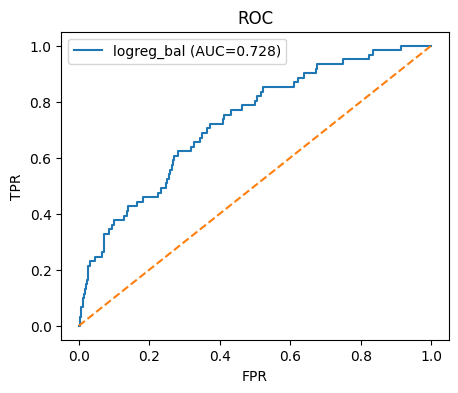

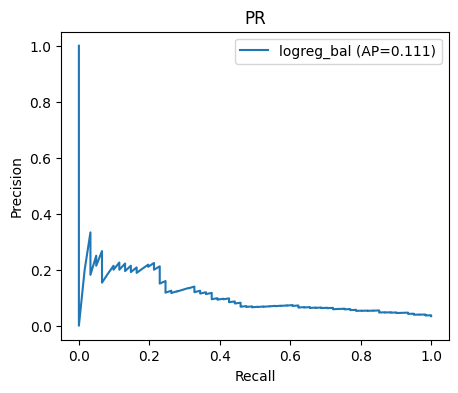

Confusion @ best_thr:
 [[1680   44]
 [  49   12]]
              precision    recall  f1-score   support

           0      0.972     0.974     0.973      1724
           1      0.214     0.197     0.205        61

    accuracy                          0.948      1785
   macro avg      0.593     0.586     0.589      1785
weighted avg      0.946     0.948     0.947      1785


=== rf_bal ===
ROC-AUC: 0.744 | PR-AUC: 0.157 | F1@best(0.18): 0.173


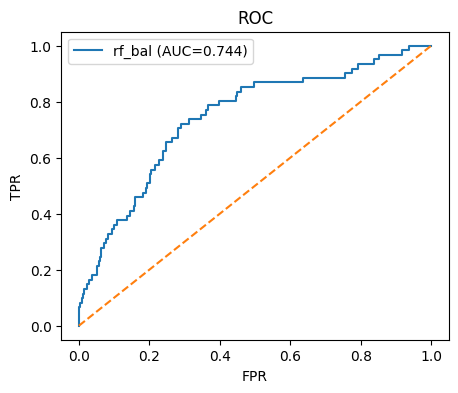

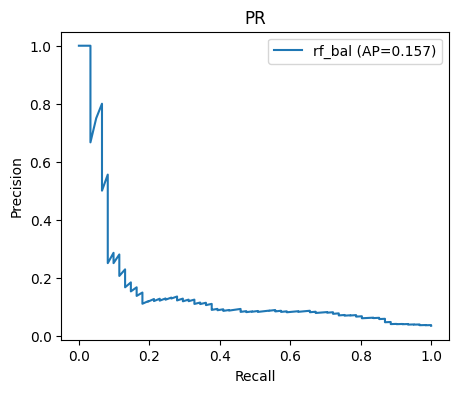

Confusion @ best_thr:
 [[1605  119]
 [  44   17]]
              precision    recall  f1-score   support

           0      0.973     0.931     0.952      1724
           1      0.125     0.279     0.173        61

    accuracy                          0.909      1785
   macro avg      0.549     0.605     0.562      1785
weighted avg      0.944     0.909     0.925      1785


=== lgbm_bal ===
ROC-AUC: 0.782 | PR-AUC: 0.215 | F1@best(0.02): 0.218


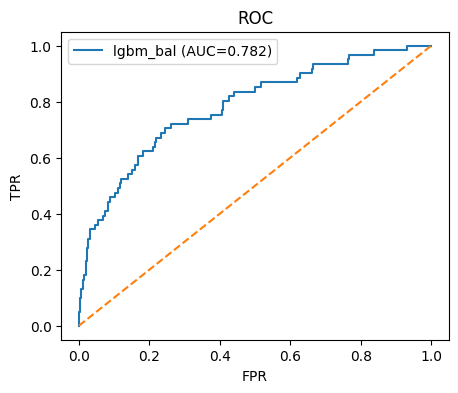

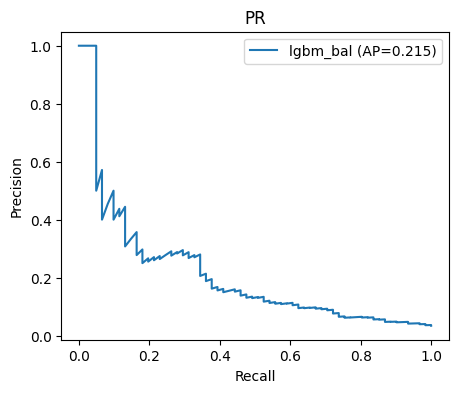

Confusion @ best_thr:
 [[1695   29]
 [  50   11]]
              precision    recall  f1-score   support

           0      0.971     0.983     0.977      1724
           1      0.275     0.180     0.218        61

    accuracy                          0.956      1785
   macro avg      0.623     0.582     0.598      1785
weighted avg      0.948     0.956     0.951      1785



,roc_auc,pr_auc,f1_best,best_thr
logreg_bal,0.728,0.111,0.205,0.94
rf_bal,0.744,0.157,0.173,0.18
lgbm_bal,0.782,0.215,0.218,0.02


In [7]:
models_base = {
    "logreg_bal": LogisticRegression(max_iter=3000, class_weight="balanced", n_jobs=-1),
    "rf_bal":     RandomForestClassifier(n_estimators=400, max_depth=12, class_weight="balanced",
                                         n_jobs=-1, random_state=42),
    "lgbm_bal":   LGBMClassifier(verbose =-1, n_estimators=600, learning_rate=0.05, num_leaves=31,
                                 class_weight="balanced", n_jobs=-1, random_state=42)
}

results_base, probas_base = {}, {}
for name, mdl in models_base.items():
    m, p = evaluate_and_curves(mdl, X_train_proc, y_train, X_valid_proc, y_valid, name=name)
    results_base[name] = m
    probas_base[name]  = p

pd.DataFrame(results_base).T.round(3)


Результаты не впечатляют, причина - сильнейший дисбаланс классов. Приненим несколько методов для их устранения и снова проведем сравнение. 

*более ли менее нормальные результаты показала модель LGBM, но порог в 0.02 совсем уж низкий, для бизнеса это не нормально, так как большинство бюджета для удержания будет "сливаться" на тех, кто и так не собирался уходить.

In [8]:
def make_dense(X):
    return X.toarray() if hasattr(X, "toarray") else X

# 1) RandomUnderSampler — балансируем примерно 1:3 (чтоб не порезать слишком сильно majority)
pos = int((y_train == 1).sum())
rus = RandomUnderSampler(
    sampling_strategy={0: pos*3, 1: pos},
    random_state=42
)
X_tr_rus, y_tr_rus = rus.fit_resample(X_train_proc, y_train)
print("[RUS] before:", dict(zip(*np.unique(y_train, return_counts=True))),
      "| after:", dict(zip(*np.unique(y_tr_rus, return_counts=True))),
      "| shapes:", X_tr_rus.shape)

# 2) SMOTE — синтетические примеры; нужен dense
X_tr_smote, y_tr_smote = SMOTE(sampling_strategy=0.33, random_state=42).fit_resample(
    make_dense(X_train_proc), y_train
)
print("[SMOTE] before:", dict(zip(*np.unique(y_train, return_counts=True))),
      "| after:", dict(zip(*np.unique(y_tr_smote, return_counts=True))),
      "| shapes:", X_tr_smote.shape)

# 3) SMOTEENN — SMOTE + чистка шумных majority
X_tr_smoteenn, y_tr_smoteenn = SMOTEENN(random_state=42).fit_resample(
    make_dense(X_train_proc), y_train
)
print("[SMOTEENN] before:", dict(zip(*np.unique(y_train, return_counts=True))),
      "| after:", dict(zip(*np.unique(y_tr_smoteenn, return_counts=True))),
      "| shapes:", X_tr_smoteenn.shape)

[RUS] before: {np.int64(0): np.int64(8040), np.int64(1): np.int64(286)} | after: {np.int64(0): np.int64(858), np.int64(1): np.int64(286)} | shapes: (1144, 335)
[SMOTE] before: {np.int64(0): np.int64(8040), np.int64(1): np.int64(286)} | after: {np.int64(0): np.int64(8040), np.int64(1): np.int64(2653)} | shapes: (10693, 335)
[SMOTEENN] before: {np.int64(0): np.int64(8040), np.int64(1): np.int64(286)} | after: {np.int64(0): np.int64(3445), np.int64(1): np.int64(8039)} | shapes: (11484, 335)



=== Sampling: RUS ===

=== logreg+RUS ===
ROC-AUC: 0.734 | PR-AUC: 0.117 | F1@best(0.94): 0.226


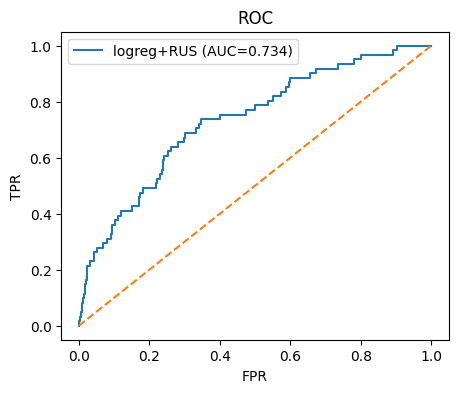

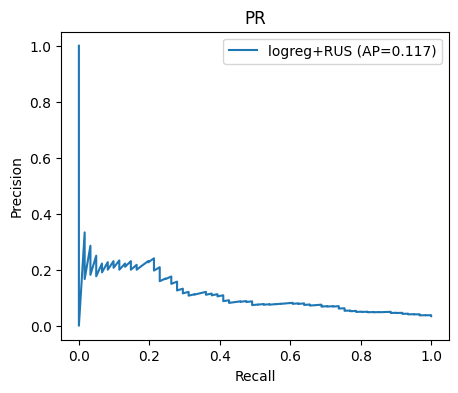

Confusion @ best_thr:
 [[1683   41]
 [  48   13]]
              precision    recall  f1-score   support

           0      0.972     0.976     0.974      1724
           1      0.241     0.213     0.226        61

    accuracy                          0.950      1785
   macro avg      0.607     0.595     0.600      1785
weighted avg      0.947     0.950     0.949      1785


=== rf+RUS ===
ROC-AUC: 0.746 | PR-AUC: 0.133 | F1@best(0.46): 0.180


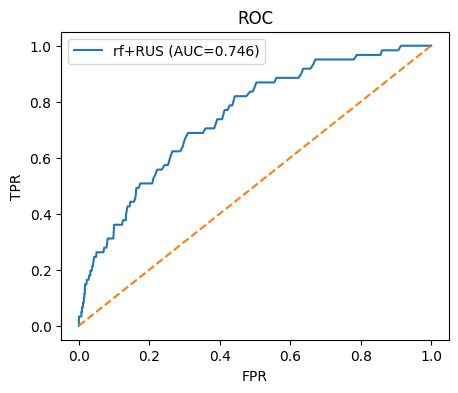

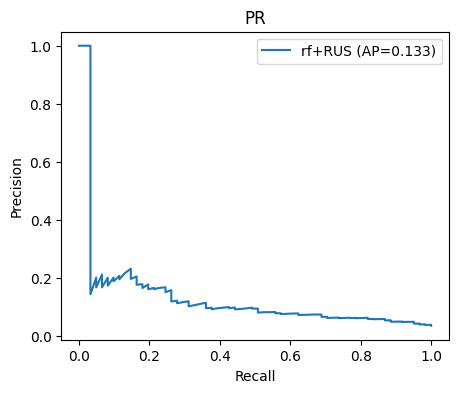

Confusion @ best_thr:
 [[1664   60]
 [  49   12]]
              precision    recall  f1-score   support

           0      0.971     0.965     0.968      1724
           1      0.167     0.197     0.180        61

    accuracy                          0.939      1785
   macro avg      0.569     0.581     0.574      1785
weighted avg      0.944     0.939     0.941      1785


=== lgbm+RUS ===
ROC-AUC: 0.797 | PR-AUC: 0.202 | F1@best(0.42): 0.251


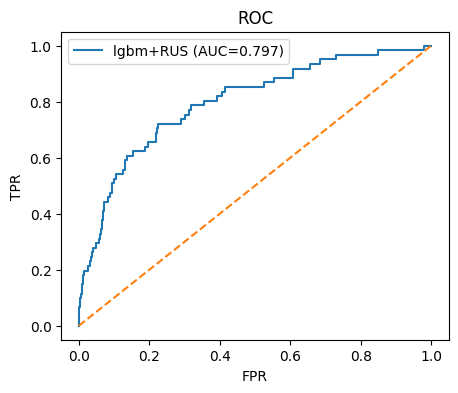

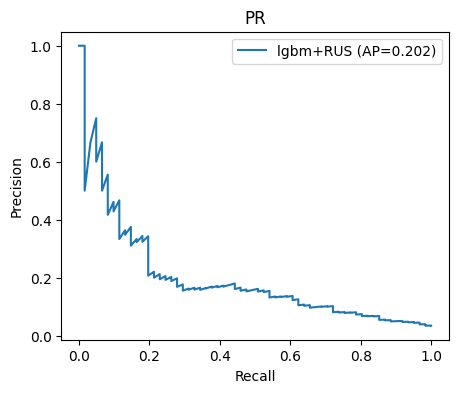

Confusion @ best_thr:
 [[1597  127]
 [  34   27]]
              precision    recall  f1-score   support

           0      0.979     0.926     0.952      1724
           1      0.175     0.443     0.251        61

    accuracy                          0.910      1785
   macro avg      0.577     0.684     0.602      1785
weighted avg      0.952     0.910     0.928      1785


=== Sampling: SMOTE ===

=== logreg+SMOTE ===
ROC-AUC: 0.723 | PR-AUC: 0.124 | F1@best(0.62): 0.196


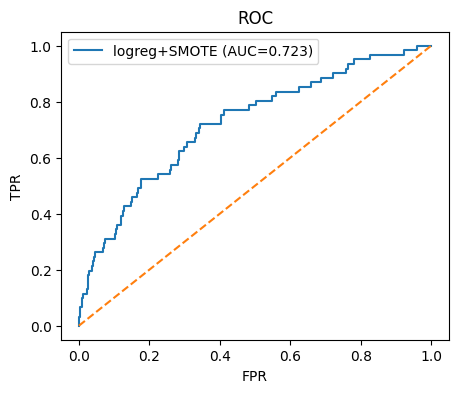

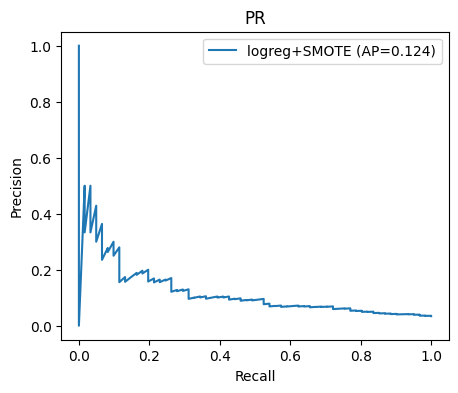

Confusion @ best_thr:
 [[1638   86]
 [  45   16]]
              precision    recall  f1-score   support

           0      0.973     0.950     0.962      1724
           1      0.157     0.262     0.196        61

    accuracy                          0.927      1785
   macro avg      0.565     0.606     0.579      1785
weighted avg      0.945     0.927     0.935      1785


=== rf+SMOTE ===
ROC-AUC: 0.713 | PR-AUC: 0.147 | F1@best(0.22): 0.252


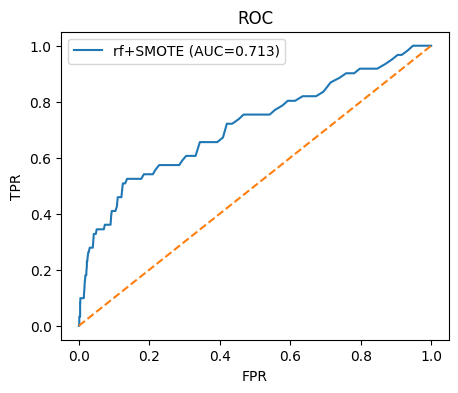

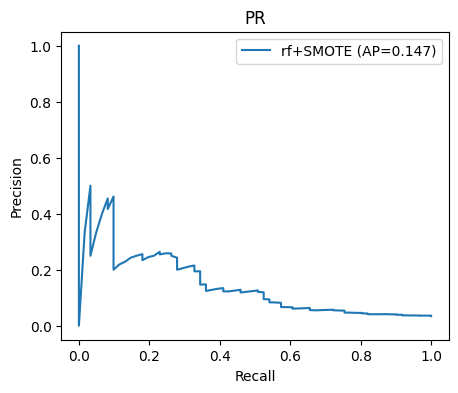

Confusion @ best_thr:
 [[1681   43]
 [  46   15]]
              precision    recall  f1-score   support

           0      0.973     0.975     0.974      1724
           1      0.259     0.246     0.252        61

    accuracy                          0.950      1785
   macro avg      0.616     0.610     0.613      1785
weighted avg      0.949     0.950     0.950      1785


=== lgbm+SMOTE ===
ROC-AUC: 0.773 | PR-AUC: 0.207 | F1@best(0.02): 0.162


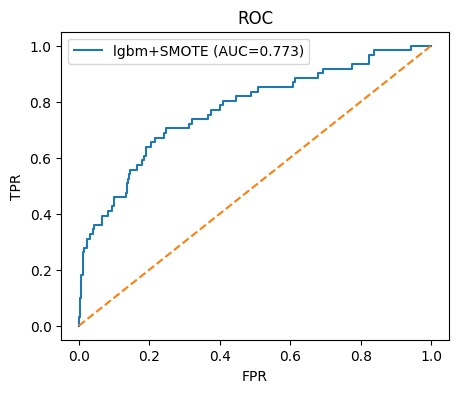

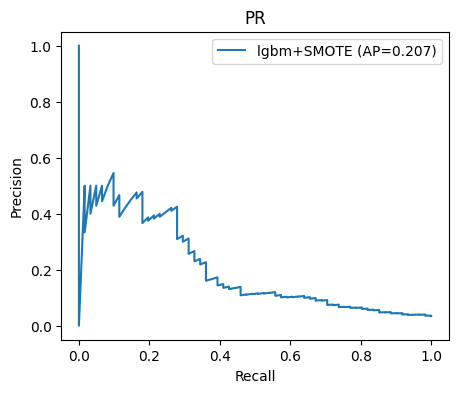

Confusion @ best_thr:
 [[1717    7]
 [  55    6]]
              precision    recall  f1-score   support

           0      0.969     0.996     0.982      1724
           1      0.462     0.098     0.162        61

    accuracy                          0.965      1785
   macro avg      0.715     0.547     0.572      1785
weighted avg      0.952     0.965     0.954      1785


=== Sampling: SMOTEENN ===

=== logreg+SMOTEENN ===
ROC-AUC: 0.712 | PR-AUC: 0.121 | F1@best(0.98): 0.229


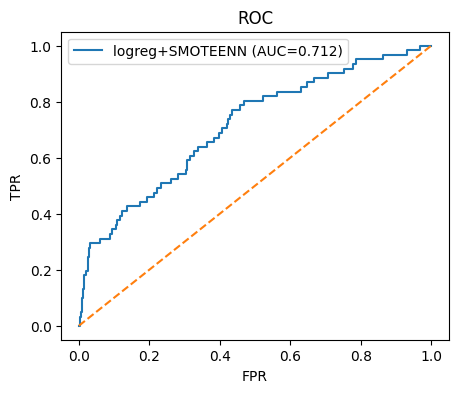

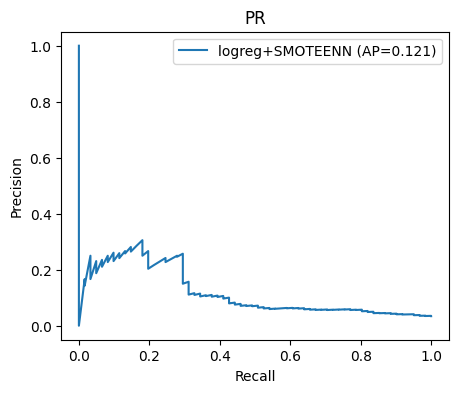

Confusion @ best_thr:
 [[1646   78]
 [  43   18]]
              precision    recall  f1-score   support

           0      0.975     0.955     0.965      1724
           1      0.188     0.295     0.229        61

    accuracy                          0.932      1785
   macro avg      0.581     0.625     0.597      1785
weighted avg      0.948     0.932     0.939      1785


=== rf+SMOTEENN ===
ROC-AUC: 0.728 | PR-AUC: 0.111 | F1@best(0.38): 0.197


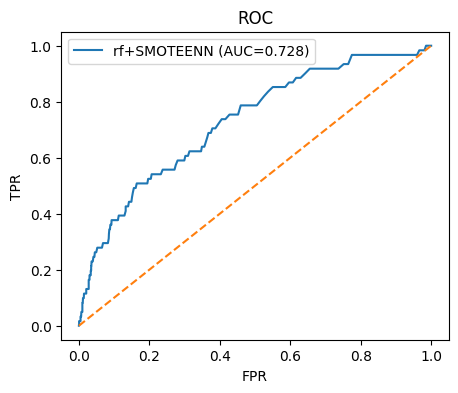

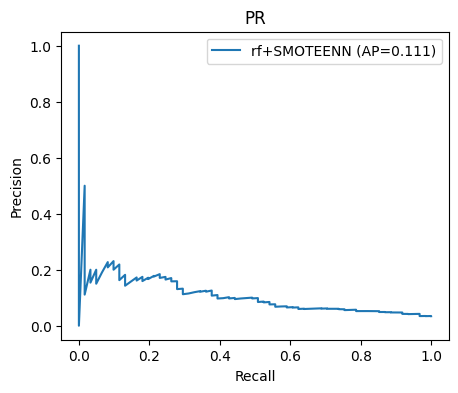

Confusion @ best_thr:
 [[1648   76]
 [  46   15]]
              precision    recall  f1-score   support

           0      0.973     0.956     0.964      1724
           1      0.165     0.246     0.197        61

    accuracy                          0.932      1785
   macro avg      0.569     0.601     0.581      1785
weighted avg      0.945     0.932     0.938      1785


=== lgbm+SMOTEENN ===
ROC-AUC: 0.765 | PR-AUC: 0.176 | F1@best(0.22): 0.276


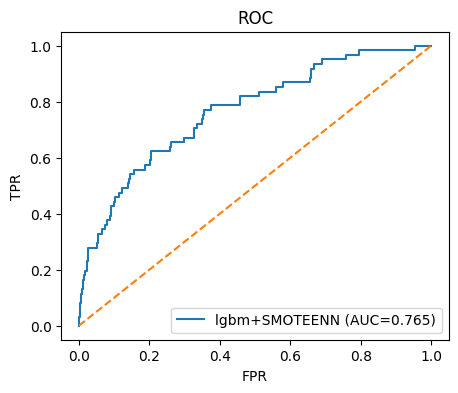

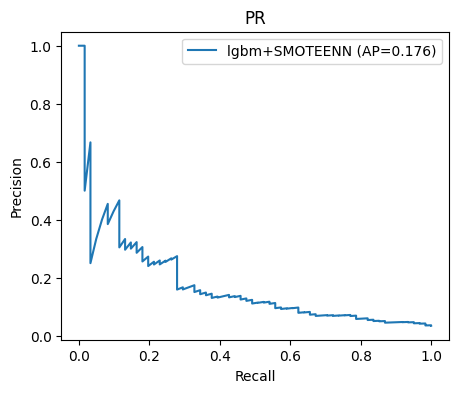

Confusion @ best_thr:
 [[1679   45]
 [  44   17]]
              precision    recall  f1-score   support

           0      0.974     0.974     0.974      1724
           1      0.274     0.279     0.276        61

    accuracy                          0.950      1785
   macro avg      0.624     0.626     0.625      1785
weighted avg      0.951     0.950     0.950      1785


[RUS]


,roc_auc,pr_auc,f1_best,best_thr
logreg,0.734,0.117,0.226,0.94
rf,0.746,0.133,0.180,0.46
lgbm,0.797,0.202,0.251,0.42



[SMOTE]


,roc_auc,pr_auc,f1_best,best_thr
logreg,0.723,0.124,0.196,0.62
rf,0.713,0.147,0.252,0.22
lgbm,0.773,0.207,0.162,0.02



[SMOTEENN]


,roc_auc,pr_auc,f1_best,best_thr
logreg,0.712,0.121,0.229,0.98
rf,0.728,0.111,0.197,0.38
lgbm,0.765,0.176,0.276,0.22


In [9]:
models_smpl = {
    "logreg": LogisticRegression(max_iter=3000, n_jobs=-1),  # без class_weight — мы уже сбалансировали
    "rf":     RandomForestClassifier(n_estimators=500, max_depth=None, n_jobs=-1, random_state=42),
    "lgbm":   LGBMClassifier(verbose=-1, n_estimators=800, learning_rate=0.05, num_leaves=63, n_jobs=-1, random_state=42)
}

def run_sampling_scenario(X_tr_s, y_tr_s, tag):
    results = {}
    print(f"\n=== Sampling: {tag} ===")
    for name, mdl in models_smpl.items():
        m, p = evaluate_and_curves(mdl, X_tr_s, y_tr_s, X_valid_proc, y_valid, name=f"{name}+{tag}")
        results[name] = m
    return pd.DataFrame(results).T

tbl_rus      = run_sampling_scenario(X_tr_rus, y_tr_rus, "RUS")
tbl_smote    = run_sampling_scenario(X_tr_smote, y_tr_smote, "SMOTE")
tbl_smoteenn = run_sampling_scenario(X_tr_smoteenn, y_tr_smoteenn, "SMOTEENN")

print("\n[RUS]"); display(tbl_rus.round(3))
print("\n[SMOTE]"); display(tbl_smote.round(3))
print("\n[SMOTEENN]"); display(tbl_smoteenn.round(3))


Результаты стали лучше: самая адекватная связка - LGBM + RUS, она дает хорошие результаты при адекватном пороге.


=== lgbm+RUS ===
ROC-AUC: 0.797 | PR-AUC: 0.202 | F1@best(0.42): 0.251


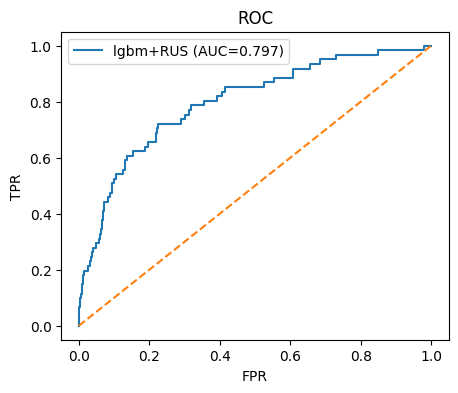

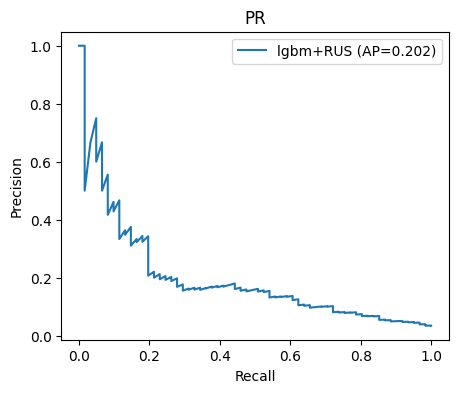

Confusion @ best_thr:
 [[1597  127]
 [  34   27]]
              precision    recall  f1-score   support

           0      0.979     0.926     0.952      1724
           1      0.175     0.443     0.251        61

    accuracy                          0.910      1785
   macro avg      0.577     0.684     0.602      1785
weighted avg      0.952     0.910     0.928      1785

FIXED best_thr from valid: 0.42000000000000004

=== TEST ===
ROC-AUC: 0.8319101593701267
PR-AUC : 0.1759779244280588
F1@best_thr(valid): 0.2523364485981308
Confusion:
 [[1598  126]
 [  34   27]]
              precision    recall  f1-score   support

           0      0.979     0.927     0.952      1724
           1      0.176     0.443     0.252        61

    accuracy                          0.910      1785
   macro avg      0.578     0.685     0.602      1785
weighted avg      0.952     0.910     0.928      1785



In [10]:
X_tr_best, y_tr_best = X_tr_rus, y_tr_rus
clf_best = LGBMClassifier(verbose=-1, n_estimators=800, learning_rate=0.05, num_leaves=63, n_jobs=-1, random_state=42)

# подбираем best_thr на валидации (чтобы не подглядывать)
m_val, p_val = evaluate_and_curves(clf_best, X_tr_best, y_tr_best, X_valid_proc, y_valid, name="lgbm+RUS")
best_thr = m_val["best_thr"]
print("FIXED best_thr from valid:", best_thr)

# финальная оценка на ТЕСТЕ
proba_test = clf_best.predict_proba(X_test_proc)[:, 1]

print("\n=== TEST ===")
print("ROC-AUC:", roc_auc_score(y_test, proba_test))
print("PR-AUC :", average_precision_score(y_test, proba_test))

pred_test = (proba_test >= best_thr).astype(int)
print("F1@best_thr(valid):", f1_score(y_test, pred_test))
print("Confusion:\n", confusion_matrix(y_test, pred_test))
print(classification_report(y_test, pred_test, digits=3))


# Выводы

- Базовые модели с class_weight показали ROC-AUC ~0.73–0.78, но при пороге 0.5 F1≈0 (жёсткий дисбаланс ~3.4%).
- Подбор порога по F1 на валидации улучшает F1 (например, у logreg thr≈0.90 → F1≈0.20).
- Семплинг на train (RUS/SMOTE/SMOTEENN) даёт прирост PR-AUC и F1@best; лучшая связка — LGBM + RUS.
- Финальная модель: LGBM + RUS. 
  - PR-AUC (valid/test): 0.202/0.175
  - ROC-AUC (valid/test): 0.797/0.831
  - F1@best_thr(valid) на тесте: 0.252
  - Фиксированный порог с валидации: 0.42.

Итоговые метрики (ROC-AUC ~0.84, PR-AUC ~0.18–0.21, F1 ~0.20–0.25) выглядят не очень большими, но это абсолютно нормально для задачи с сильным дисбалансом классов (churn ≈ 3%).

PR-AUC и F1-score всегда «просаживаются» при редких событиях — ведь даже поймав часть уходящих клиентов, мы по цифрам всё равно остаёмся в низких значениях.

Для бизнеса этого достаточно: даже +5–10% клиентов, которых мы предскажем и удержим, могут давать большую экономию/выручку.
